In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import umap
import hdbscan
from IPython.display import display

In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [3]:
# Load the original dataset
file_path = "News_Category_Dataset_v3.json"  # Update with actual path
df = pd.read_json(file_path, lines=True)

In [4]:
# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Number of rows in original dataset: 209527
Number of columns in original dataset: 6


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


C:\Users\Ella\AppData\Local\Temp\ipykernel_18356\3223137788.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [5]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenization, Stopword Removal, and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [7]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', max_df=0.6, min_df=3, ngram_range=(1,3))
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=min(X.shape[1], 3800), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by selected components: {explained_variance:.4f}")

Total explained variance by selected components: 0.9056


In [9]:
# UMAP for further dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ella\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [11]:
# Perform Clustering using HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')
labels_hdbscan = hdbscan_clusterer.fit_predict(X_normalized)

# Add cluster labels to DataFrame
df['cluster_hdbscan'] = labels_hdbscan

# Clustering Metrics (excluding silhouette for HDBSCAN since it allows noise)
hdbscan_metrics = {
    'davies_bouldin': davies_bouldin_score(X_normalized, labels_hdbscan) if len(set(labels_hdbscan)) > 1 else None,
    'calinski_harabasz': calinski_harabasz_score(X_normalized, labels_hdbscan) if len(set(labels_hdbscan)) > 1 else None,
    'similarity': cosine_similarity(X_normalized).mean()
}

print("\nHDBSCAN Clustering Metrics:")
for key, value in hdbscan_metrics.items():
    print(f"{key}: {value:.4f}" if value else f"{key}: Not applicable (only one cluster detected)")

c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



HDBSCAN Clustering Metrics:
davies_bouldin: 1.5234
calinski_harabasz: 165.2121
similarity: 0.0004


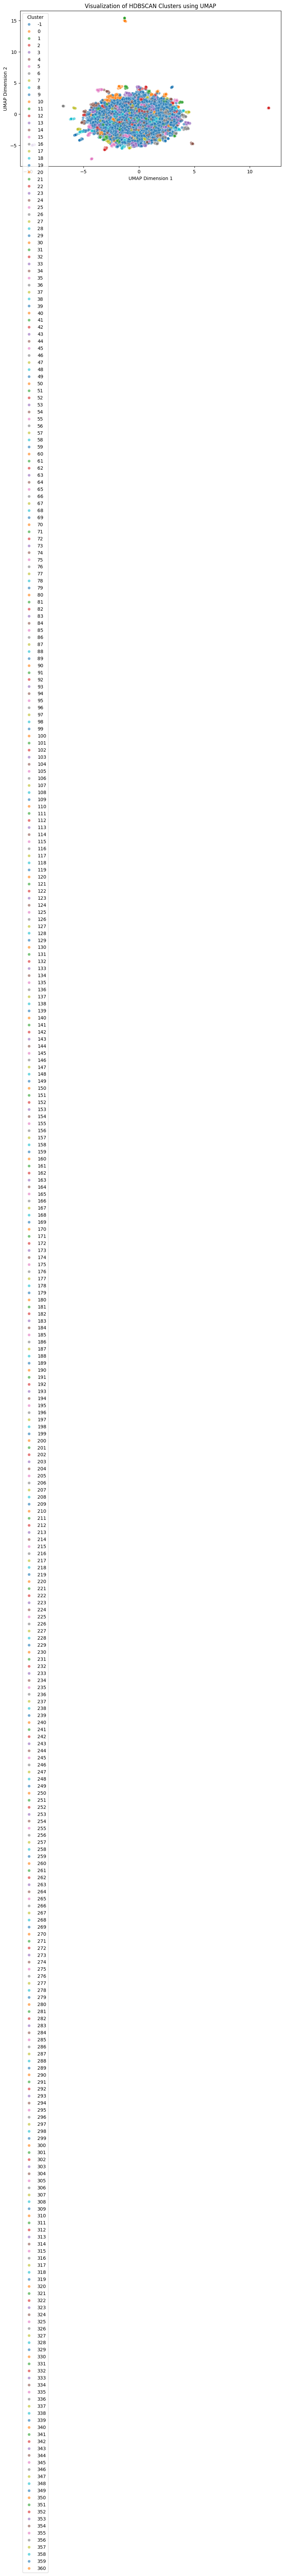

In [12]:
# Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_hdbscan, palette='tab10', alpha=0.6)
plt.title('Visualization of HDBSCAN Clusters using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()

In [13]:
# Cluster Profiling for HDBSCAN
num_clusters = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)  # Excluding noise (-1)
print(f"\nCluster Profiles for HDBSCAN with {num_clusters} Clusters")

for cluster_num in sorted(set(labels_hdbscan)):
    if cluster_num == -1:
        print("\nCluster -1 (Noise / Outliers)")
        continue  # Skip noise cluster

    cluster_data = df[df['cluster_hdbscan'] == cluster_num]

    if cluster_data.empty:
        print(f"Cluster {cluster_num} is empty.")
        continue

    most_common_words = pd.Series(' '.join(cluster_data['filtered_text']).split()).value_counts().head(10)

    print(f"\nCluster {cluster_num}:")
    print(most_common_words)
    print("-" * 40)


Cluster Profiles for HDBSCAN with 361 Clusters

Cluster -1 (Noise / Outliers)

Cluster 0:
tweet       58
funniest    57
woman       57
week        57
oct         12
im           7
sept         6
may          5
would        5
people       5
Name: count, dtype: int64
----------------------------------------

Cluster 1:
woman       45
week        45
funniest    23
tweet       23
lady        23
twitter     22
never       22
fail        22
brighten    22
day         22
Name: count, dtype: int64
----------------------------------------

Cluster 2:
huffpost     108
hill         108
like          65
get           63
news          62
political     62
dose          61
evening       61
every         61
read          61
Name: count, dtype: int64
----------------------------------------

Cluster 3:
parent       57
tweet        55
funniest     54
week         54
kid          26
may          19
thing        13
say          12
hilarious    12
round        12
Name: count, dtype: int64
----------------